In [1]:
# -- imports
%matplotlib inline
import numpy as np
import os
import pandas as pd
from config import *
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

In [2]:
#upload the file with labels 0 or 1.
#this file is only for the data that I have on my computer. stamps0 (aunque diga stamps1)
ffpath = os.path.join(configs["dpath"], "autoscan_features.stamps1exp.feather") #this .feather file contain only the ID and OBJECT_TYPE for the images that I have on my computer
new_labels = pd.read_feather(ffpath)

# dropping ALL duplicte values 
new_labels.drop_duplicates(inplace=True) 
#sort by label, first 0 and then 1
new_labels = new_labels.sort_values(by=['OBJECT_TYPE'])
#reset the index
new_labels = new_labels.reset_index(drop = True)
  
# displaying data 
new_labels

ID  OBJECT_TYPE
0     7035645            0
1     7002844            0
2     7056920            0
3     7002913            0
4     7056212            0
...       ...          ...
2682  7035311            1
2683  7035318            1
2684  7035682            1
2685  7035155            1
2686  7771834            1

[2687 rows x 2 columns]

In [3]:
#counts for 0 type and 1 type
counts_type = np.unique(new_labels['OBJECT_TYPE'], return_counts=True)
print("0 = {} and 1 = {}".format(counts_type[1][0], counts_type[1][1]))

0 = 790 and 1 = 1897


In [4]:
#just 0 type
#ID_0 = np.sort(new_labels.query('OBJECT_TYPE==0')['ID'].to_numpy())
#len(ID_0)

#1 is BOGUSS!!
new_labels1 = new_labels.query("OBJECT_TYPE==1")
#new_labels0.sort_index()
ID_1 = new_labels1.sort_values(by=['ID']).reset_index(drop = True)

In [5]:
ID_1

ID  OBJECT_TYPE
0     6960252            1
1     6961062            1
2     6961064            1
3     6961300            1
4     6961332            1
...       ...          ...
1892  7778287            1
1893  7778592            1
1894  7778883            1
1895  7779002            1
1896  7779022            1

[1897 rows x 2 columns]

In [6]:
ID_1.iloc[65]['ID']

6964012

In [7]:
#Create path for diff, srch, temp images
pttype = '*'

srch1 = os.path.join(configs["dpath"],'Stamps1','20130829', '*',pttype + '*.fits') #general path of the images 
srch2 = os.path.join(configs["dpath"],'Stamps1','20130831', '*',pttype + '*.fits')
srch3 = os.path.join(configs["dpath"],'Stamps1','20130901', '*',pttype + '*.fits')
flist1  = np.array(sorted(glob.glob(srch1))) #recorre el path por *, recorre temp, srch y diff y el *.fits por el numero de la imagen
flist2  = np.array(sorted(glob.glob(srch2)))
flist3  = np.array(sorted(glob.glob(srch3)))
flist = np.concatenate((flist1,flist2,flist3))

In [8]:
flist

array(['/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470430504/diff6962491.fits',
       '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470430504/srch6962491.fits',
       '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470430504/temp6962491.fits',
       ...,
       '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472357109/temp7771805.fits',
       '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472357109/temp7771807.fits',
       '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472357109/temp7771834.fits'],
      dtype='<U94')

In [9]:
# path for the images that I want, the 0 type
imlist_dict = {}

# stores the name of the images as a list for ID_0 above
imlist_dict['flist_bogcl'] = [f for f in flist if int(f.split('/')[-1][4:-5]) in ID_1['ID'].to_numpy()]
print (len(imlist_dict['flist_bogcl']))


#N = imlist_dict["nimgs"] = int(imlist_dict["fnumbers"].shape[0]) 

#shape of the images
imlist_dict["imshp"] = fits.open((imlist_dict["flist_bogcl"][0]))[0].data.shape #shape row,col
extension="fits"
imdtype = {"fits":float, "gif":np.uint8, }

5691


In [10]:
imlist_dict["flist_bogcl"] = sorted(imlist_dict["flist_bogcl"], key=lambda s: s.split('/')[-1][:4])
imlist_dict["flist_bogcl"]= sorted(imlist_dict["flist_bogcl"], key=lambda s: s.split('/')[-1][4:])
imlist_dict["flist_bogcl"][:9]

['/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681007/diff6960252.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681007/srch6960252.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681007/temp6960252.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/diff6961062.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/srch6961062.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/temp6961062.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/diff6961064.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/srch6961064.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/temp6961064.fits']

In [11]:
#container for bogcl data
boglc = np.zeros((len(imlist_dict["flist_bogcl"]),imlist_dict["imshp"][0], imlist_dict["imshp"][1]),imdtype[extension])


#fill the container and open images
for i in range(len(imlist_dict["flist_bogcl"])):
    boglc[i] = fits.open(''.join(imlist_dict["flist_bogcl"][i]))[0].data

In [12]:
#convert float for normalize
boglc_norm = boglc.astype(float)

# --normalize
# mean and std for diff images
# min and max for srch and temp

#bogcl
boglc_norm[::3] = (boglc_norm[::3]- boglc_norm[::3].mean(axis=(1,2), keepdims=True))/boglc_norm[::3].std(axis=(1,2), keepdims=True) #diff
    
boglc_norm[1::3]= (boglc_norm[1::3]-boglc_norm[1::3].min(axis=(1,2), keepdims=True))/boglc_norm[1::3].max(axis=(1,2), keepdims=True) #srch
boglc_norm[2::3]= (boglc_norm[2::3]-boglc_norm[2::3].min(axis=(1,2), keepdims=True))/boglc_norm[2::3].max(axis=(1,2), keepdims=True) #temp


In [13]:
boglc_norm.shape

(5691, 51, 51)

In [14]:
#concatenate diff srch temp for the same ID

#bogcl
final_bogcl = np.zeros((int(len(boglc)//3),imlist_dict["imshp"][0], imlist_dict["imshp"][1]*3))
final_bogcl = np.concatenate((boglc_norm[::3],boglc_norm[1::3],boglc_norm[2::3]), axis = 2)
#final_bogcl  = final_bogcl.transpose(0,2,1)
nonorm_bogcl = np.concatenate((boglc[::3],boglc[1::3],boglc[2::3]), axis = 2)

print('Final lenght of bogcl = {}'.format(final_bogcl.shape))    

Final lenght of bogcl = (1897, 51, 153)


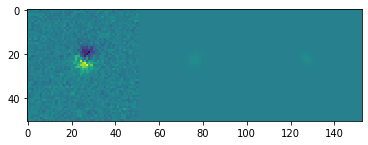

In [15]:
plt.imshow(final_bogcl[4])

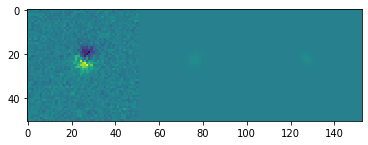

In [16]:
plt.imshow(np.hstack((boglc_norm[4*3],boglc_norm[(4*3)+1],boglc_norm[(4*3)+2])))

In [17]:
np.random.seed(1)
tf.random.set_seed(3425)

# -- define the network
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="valid", activation="relu", input_shape=(51, 153, 1))
layer2 = keras.layers.MaxPooling2D((2, 2), strides=2)
layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="valid", activation="relu", input_shape=(51, 153, 1))
layer4 = keras.layers.MaxPooling2D((2, 2), strides=2)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(32, activation="relu")
#layer7 = keras.layers.Dropout(0.6)
layer7 = keras.layers.Dense(2, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate the convolutional neural network
model = keras.Sequential(layers)

opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- feautres need to have an extra axis on the end (for mini-batching)
bogcl2 = final_bogcl.reshape(int(len(boglc)//3), 51, 153, 1)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 149, 16)       416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 70, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 35, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10080)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                322592    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6

In [19]:
# extract the hidden layer for layer6 = Dense(32)
get_6rd_layer_output = tf.keras.backend.function([model.layers[0].input],
                                  [model.layers[5].output])
#input = 0 type
layer_output = get_6rd_layer_output([bogcl2])

In [20]:
#what is the shape: each image has 32 "features"
layer_output[0].shape

(1897, 32)

In [21]:
layer_output[0].mean()

0.1252684

In [22]:
layer_output[0].max()

1.1964706

In [23]:
layer_output[0].min()

-0.0

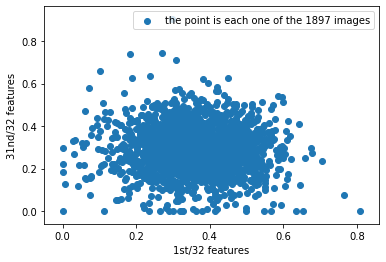

In [24]:
#plot the first vs second features (just curious)
plt.scatter(layer_output[0][:,1],layer_output[0][:,31], label = "the point is each one of the 1897 images")
plt.xlabel("1st/32 features")
plt.ylabel("31nd/32 features")
plt.legend()

# KMeans for n_cluster = [2,3,4,5,6]

In [25]:
from sklearn.cluster import KMeans

In [26]:
plt.style.use("bmh")

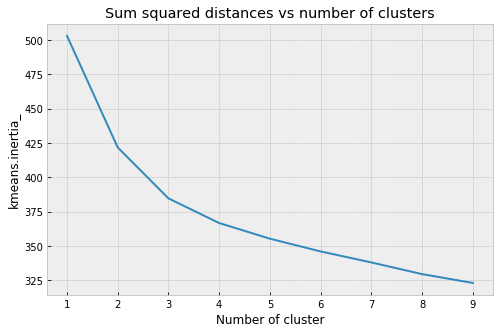

In [27]:
#Elbow method to determine the best number of cluster: the one with smallest distance
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=3425).fit(layer_output[0])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
#plt.figure()
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(list(sse.keys()), list(sse.values()))
#plt.grid(True)
ax.set_xlabel("Number of cluster")
ax.set_ylabel("kmeans.inertia_")
ax.set_title("Sum squared distances vs number of clusters")
#fig.show()
#plt.savefig("elbow.pdf",bbox_inches="tight")
#it looks like is n_clusters = 5

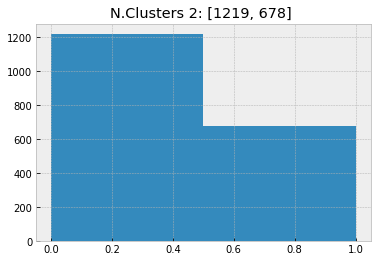

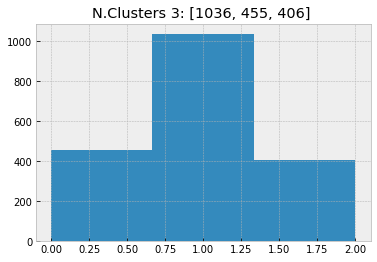

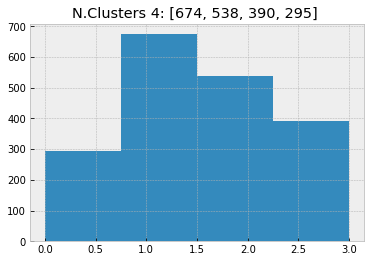

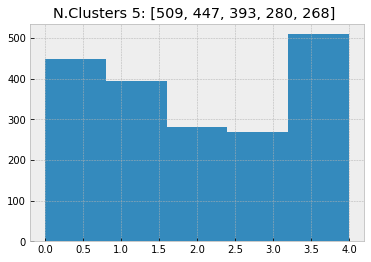

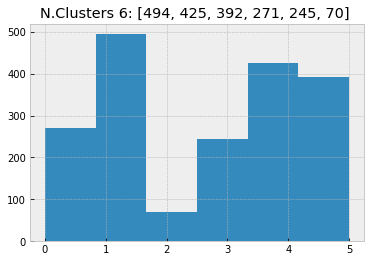

In [28]:
#implements Kmeans from the library sklearn.As the name, it cluster the data in the n_clusters
#that I define
cluster_map = pd.DataFrame()
for i in [2,3,4,5,6]:
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=3425).fit(layer_output[0])
    #kmeans = KMeans(n_clusters=i,init='k-means++',random_state=8989).fit(layer_output[0])
    #kmeans = KMeans(n_clusters=i,init='random',random_state=8989).fit(layer_output[0])
    #extract the label (0-4) of the cluster and the index 
    
    cluster_map['cluster%d'%i] = kmeans.labels_
    
    
    plt.figure()
    plt.title("N.Clusters %d: %s "%(i, list(cluster_map['cluster%d'%i].value_counts())))
    plt.hist(kmeans.labels_, bins=i)
    plt.text

In [28]:
#k++ random-state = 34
for i in [2,3,4,5,6]:
    print(list(cluster_map['cluster%d'%i].value_counts()))

[1219, 678]
[1036, 455, 406]
[674, 538, 390, 295]
[509, 447, 393, 280, 268]
[494, 425, 392, 271, 245, 70]


In [29]:
#random-state: 8989
for i in [2,3,4,5,6]:
    print(list(cluster_map['cluster%d'%i].value_counts()))

[1219, 678]
[1036, 455, 406]
[674, 538, 390, 295]
[509, 447, 393, 280, 268]
[494, 425, 392, 271, 245, 70]


In [30]:
#random and random-state: 8989
for i in [2,3,4,5,6]:
    print(list(cluster_map['cluster%d'%i].value_counts()))

[1219, 678]
[1036, 455, 406]
[674, 538, 390, 295]
[509, 447, 393, 280, 268]
[494, 425, 392, 271, 245, 70]


In [29]:
cluster_map

cluster2  cluster3  cluster4  cluster5  cluster6
0            0         1         1         4         1
1            1         2         3         3         3
2            1         0         2         0         4
3            1         2         3         3         3
4            1         0         0         2         0
...        ...       ...       ...       ...       ...
1892         1         2         3         3         3
1893         0         2         3         1         5
1894         1         2         3         3         2
1895         0         1         1         4         1
1896         0         1         1         1         5

[1897 rows x 5 columns]

# Plot mean hist for each cluster

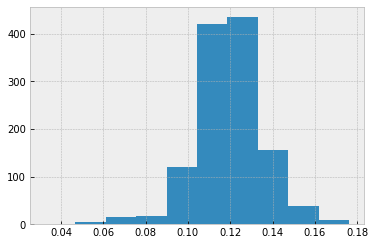

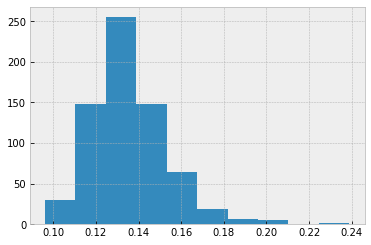

In [30]:
#plot mean cluster = 2
index = {}
for k in range(2):
    plt.figure()
    index[k] = [j for j in cluster_map.index if cluster_map.loc[j]['cluster2'] == k]
    plt.hist(np.array(layer_output[0][index[k]]).mean(axis = 1))

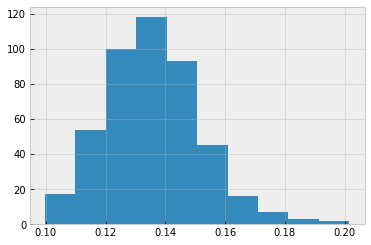

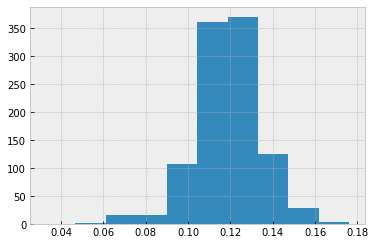

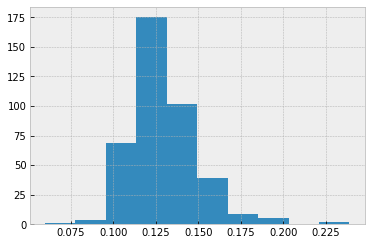

In [31]:
#plot mean cluster = 3
index = {}
for k in range(3):
    plt.figure()
    index[k] = [j for j in cluster_map.index if cluster_map.loc[j]['cluster3'] == k]
    plt.hist(np.array(layer_output[0][index[k]]).mean(axis = 1))

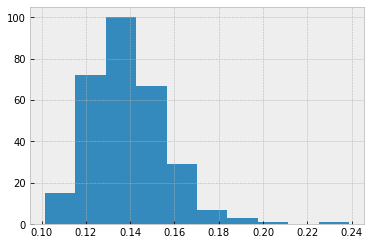

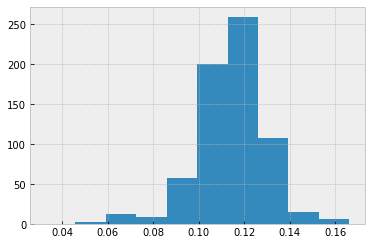

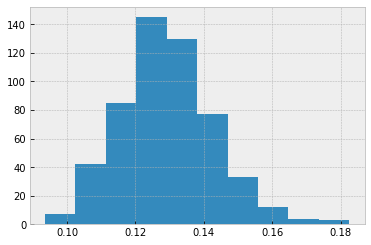

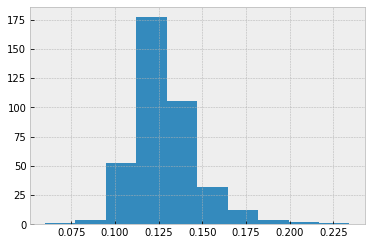

In [32]:
#plot mean cluster = 4
index = {}
for k in range(4):
    plt.figure()
    index[k] = [j for j in cluster_map.index if cluster_map.loc[j]['cluster4'] == k]
    plt.hist(np.array(layer_output[0][index[k]]).mean(axis = 1))

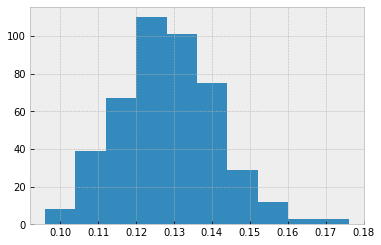

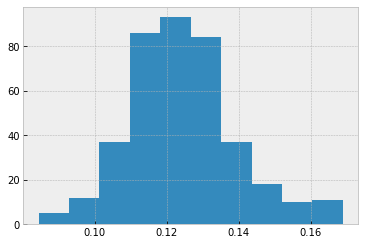

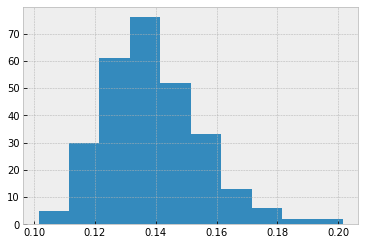

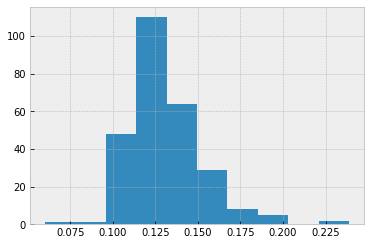

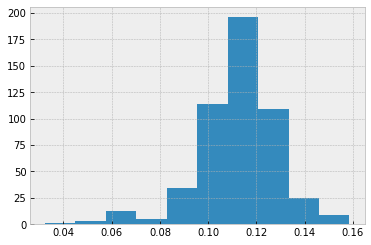

In [33]:
#plot mean cluster = 5
index = {}
for k in range(5):
    plt.figure()
    index[k] = [j for j in cluster_map.index if cluster_map.loc[j]['cluster5'] == k]
    plt.hist(np.array(layer_output[0][index[k]]).mean(axis = 1))

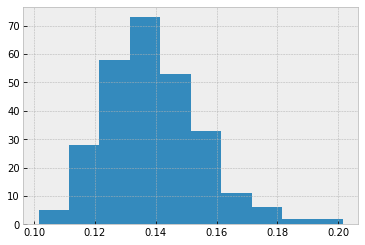

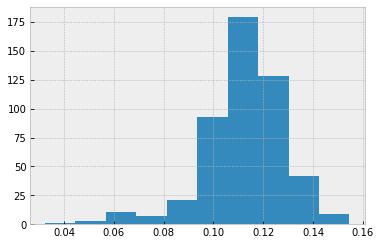

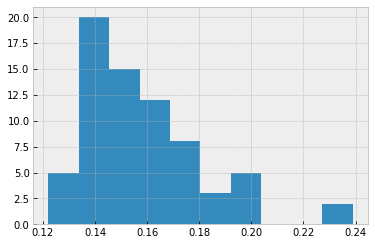

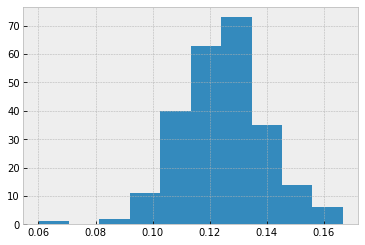

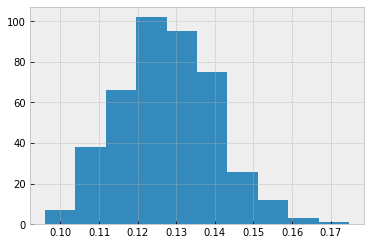

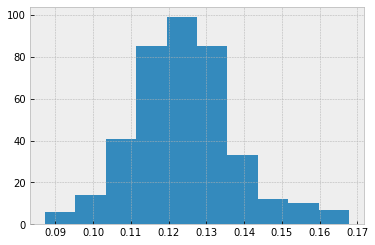

In [34]:
#plot mean cluster = 6
index = {}
for k in range(6):
    plt.figure()
    index[k] = [j for j in cluster_map.index if cluster_map.loc[j]['cluster6'] == k]
    plt.hist(np.array(layer_output[0][index[k]]).mean(axis = 1))

# TSNE with perplexity = 8 and 50

In [35]:
from sklearn.manifold import TSNE

In [36]:
#tsne_8 = TSNE(n_components = 2, perplexity = 8,early_exaggeration = 5, learning_rate = 500,n_iter = 2000,random_state=3425).fit_transform(layer_output[0])
#tsne_50 = TSNE(n_components = 2, perplexity = 50,early_exaggeration = 5, learning_rate = 500,n_iter = 2000,random_state=3425).fit_transform(layer_output[0])
#tsne_8 = TSNE(n_components = 2, perplexity = 8,early_exaggeration = 35,learning_rate = 800,n_iter = 3000,random_state=3425).fit_transform(layer_output[0])
tsne_50 = TSNE(n_components = 2, perplexity = 50,early_exaggeration = 35,learning_rate = 800,n_iter = 3000,random_state=3425).fit_transform(layer_output[0])

Text(0, 0.5, 'tsne_50_y')

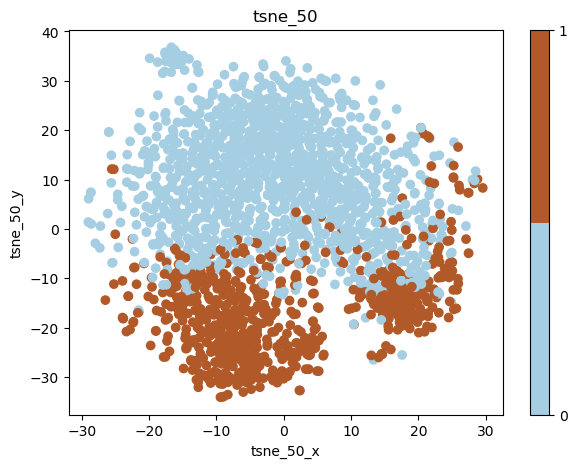

In [37]:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (7,5))
#ax[0].scatter(tsne_8[:,0], tsne_8[:,1], c = cluster_map['cluster2'], label = cluster_map['cluster2'].value_counts())
#ax[0].set_title("tsne_8 \n %s" %cluster_map['cluster2'].value_counts())


#ax[1].scatter(tsne_50[:,0], tsne_50[:,1], c = cluster_map['cluster2'])
#ass = ax.scatter(tsne_50[:,0], tsne_50[:,1], clim=[-0.5, 2 - 0.5], c = cluster_map['cluster2'])
#ass = ax.scatter(tsne_50[:,0], tsne_50[:,1], c = cluster_map['cluster2'],cmap = 'Paired')
#ax.set_title("tsne_50")
cmap = plt.get_cmap('Paired', 2)
scatter2 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = cluster_map['cluster2'],cmap = cmap)
plt.colorbar(scatter2, ticks = [0,1])
plt.title("tsne_50")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

#plt.savefig("tsne50+2kmean.pdf",bbox_inches="tight")


#fig.colorbar(ax[1].scatter(tsne_50[:,0], tsne_50[:,1], c = cluster_map['cluster2']))
#fig.colorbar(ass, ticks=range(2))
    

# Plot the group top left section

In [38]:
np.argmax(tsne_50[:,1])

1277

In [39]:
#tsne_50[:,1]
tsne_y_gr_30 = [(np.where(tsne_50[:,1] == i)[0][0], i) for i in tsne_50[:,1] if i > 30]
tsne_x_less_m15 = [(np.where(tsne_50[:,0] == i)[0][0], i) for i in tsne_50[:,0] if i < -15 and i > -20]

In [40]:
group_TL = pd.merge(pd.DataFrame(tsne_y_gr_30,columns=['index', "tsne_y_50"]),pd.DataFrame(tsne_x_less_m15,columns=['index', "tsne_x_50"]))
len(group_TL)

27

## Normalized

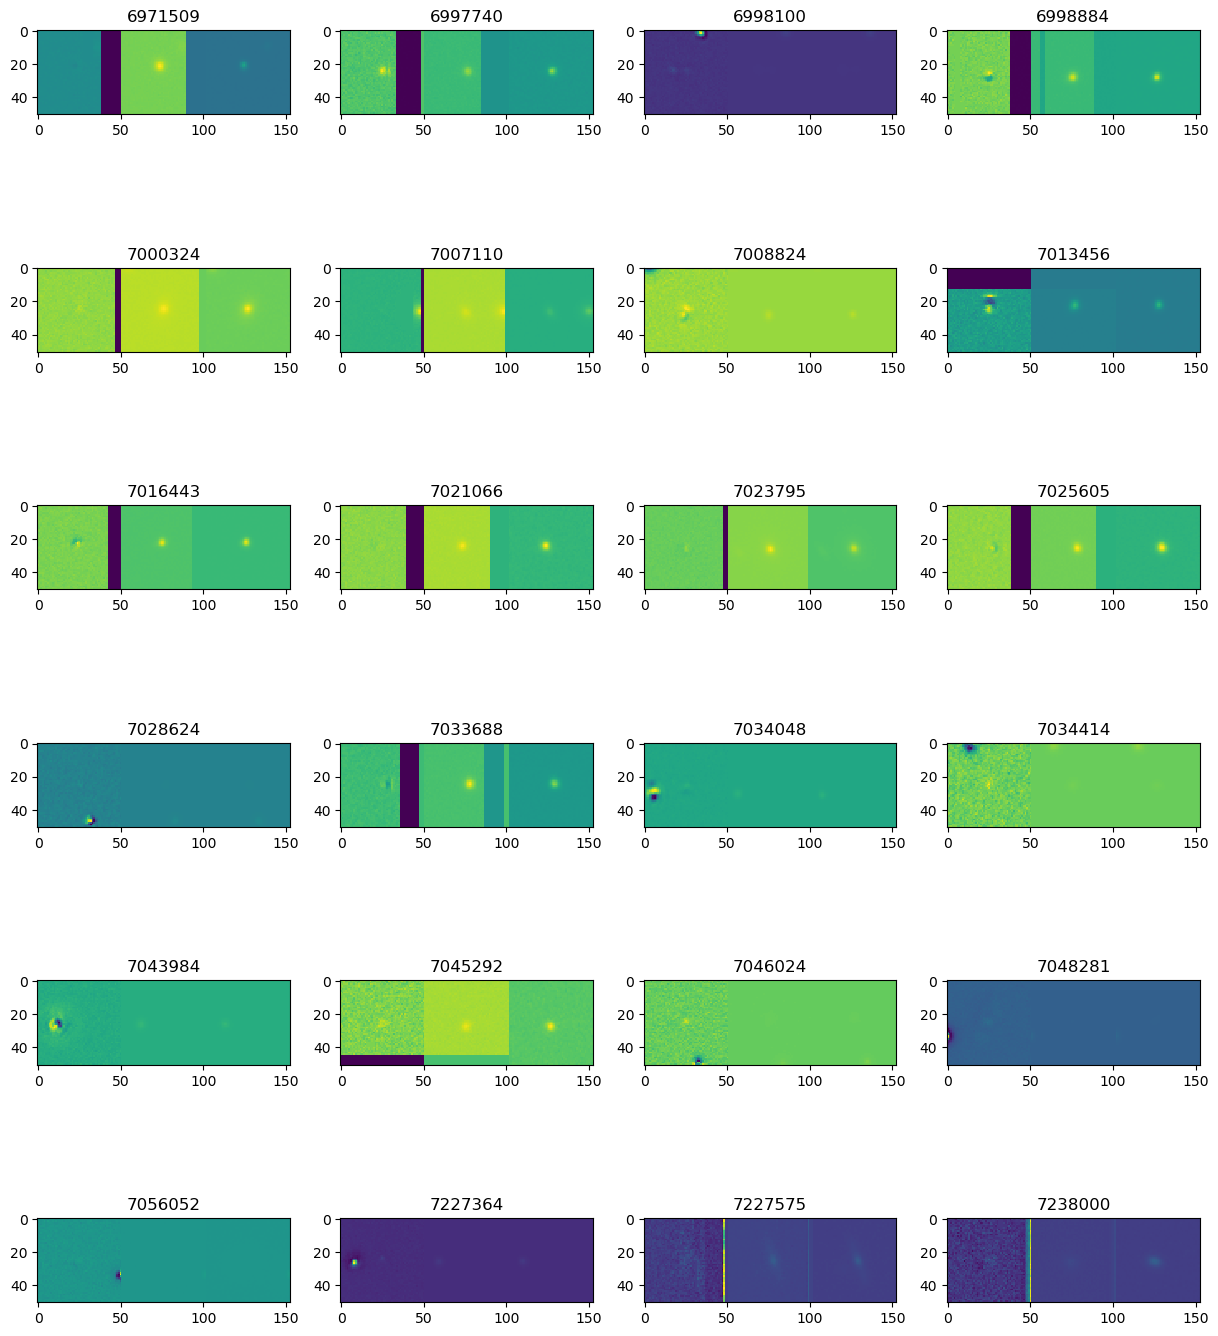

In [72]:
#a2 = [reee["index"][i] for i in range(len(reee)) if reee["index"][i] in cluster_map[cluster_map['cluster2'] == 0].index.to_numpy()]
fig, ax = plt.subplots(6,4, figsize= (15,18))
l = 0
for i in range(6):
    for j in range(4):
        ax[i,j].imshow(final_bogcl[group_TL["index"][l]])
        ax[i,j].set_title("{}".format(ID_1.iloc[group_TL["index"][l]]["ID"]))
        l = l+1
fig.savefig("sera.pdf",bbox_inches="tight")


In [44]:
IDss = []
for l in range(27):
    IDss.append(ID_1.iloc[group_TL["index"][l]]["ID"])
IDss

[6971509,
 6997740,
 6998100,
 6998884,
 7000324,
 7007110,
 7008824,
 7013456,
 7016443,
 7021066,
 7023795,
 7025605,
 7028624,
 7033688,
 7034048,
 7034414,
 7043984,
 7045292,
 7046024,
 7048281,
 7056052,
 7227364,
 7227575,
 7238000,
 7472382,
 7695348,
 7772671]

## No normalized

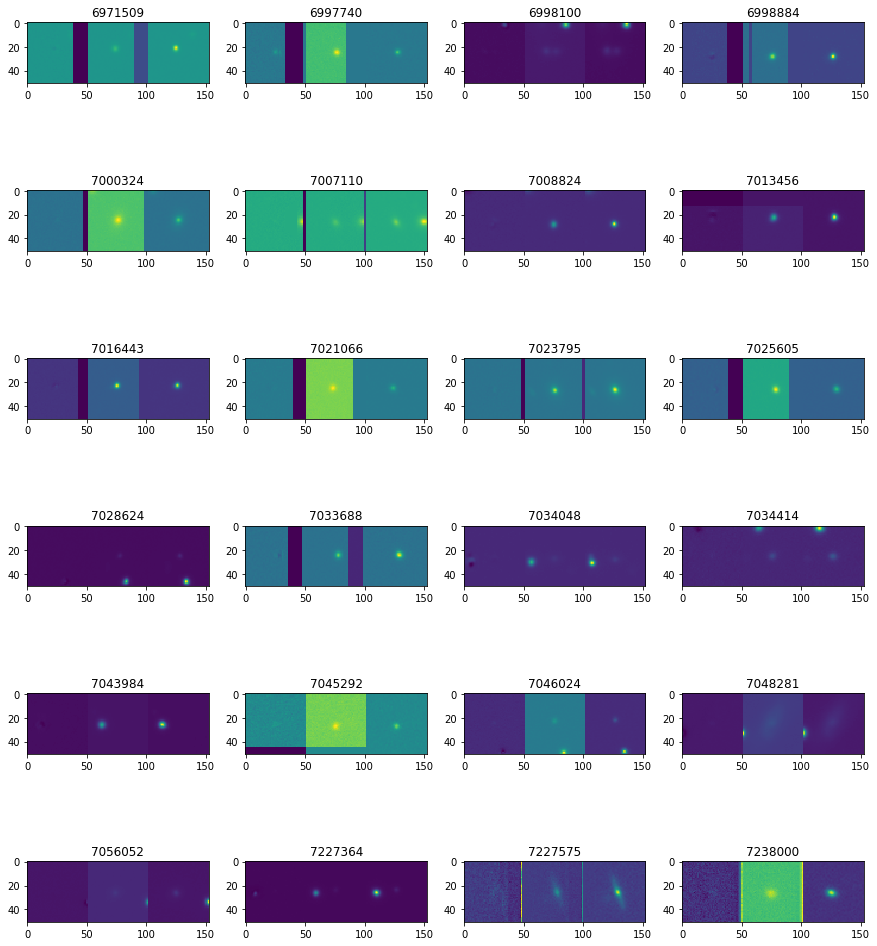

In [45]:
fig, ax = plt.subplots(6,4, figsize= (15,18))
l = 0
for i in range(6):
    for j in range(4):
        ax[i,j].imshow(nonorm_bogcl[group_TL["index"][l]])
        ax[i,j].set_title("{}".format(ID_1.iloc[group_TL["index"][l]]["ID"]))
        l = l+1

In [41]:
random_index_TL = group_TL["index"].sample(8, random_state = 4)

In [42]:
random_index_TL.reset_index(drop = True)[1]

1089

In [43]:
ID_1.iloc[random_index_TL.reset_index(drop = True)[1]]["ID"]

7043984

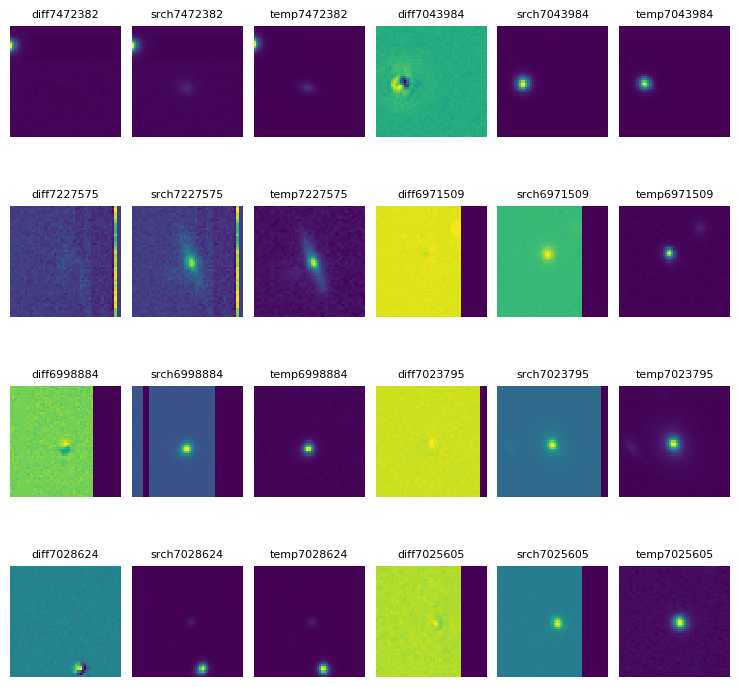

In [166]:
# fig, ax = plt.subplots(6,4*3, figsize= (15,15))
# fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.1, -0.0001)
# l = 0
# for i in range(24*3):
#     ax[i//12,i%12].axis("off")
#     ax[i//12,i%12].imshow(boglc_norm[group_TL["index"][i//3]*3+i%3])
#     ax[i//12,i%12].set_title("{}".format(ID_1.iloc[group_TL["index"][i//3]]["ID"]), fontsize = 8) 


fig, ax = plt.subplots(4,2*3, figsize= (8,8))
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.1, -0.0001)
for i in range(8*3):
    ax[i//6,i%6].axis("off")
    ax[i//6,i%6].imshow(boglc_norm[random_index_TL.reset_index(drop = True)[i//3]*3+i%3])
    ax[i//6,i%6].set_title("{}{}".format(flist[i%3].split('/')[-1][0:4],ID_1.iloc[random_index_TL.reset_index(drop = True)[i//3]]["ID"]), fontsize = 8) 
#plt.savefig("tsnegroupTL.pdf",bbox_inches="tight")


# Plot group bottom right section

In [44]:
tsne_y_gr_m30 = [(np.where(tsne_50[:,1] == i)[0][0], i) for i in tsne_50[:,1] if i > -30 and i < -23]
tsne_x_10_20 = [(np.where(tsne_50[:,0] == i)[0][0], i) for i in tsne_50[:,0] if i < 20 and i > 10]

In [45]:
group_BR = pd.merge(pd.DataFrame(tsne_y_gr_m30,columns=['index', "tsne_y_50"]),pd.DataFrame(tsne_x_10_20,columns=['index', "tsne_x_50"]))
len(group_BR)

9

In [46]:
IDss = []
for l in range(9):
    IDss.append(ID_1.iloc[group_BR["index"][l]]["ID"])
IDss

[7036262,
 7045445,
 7048079,
 7052131,
 7052223,
 7239672,
 7292366,
 7694527,
 7778236]

## Normalized

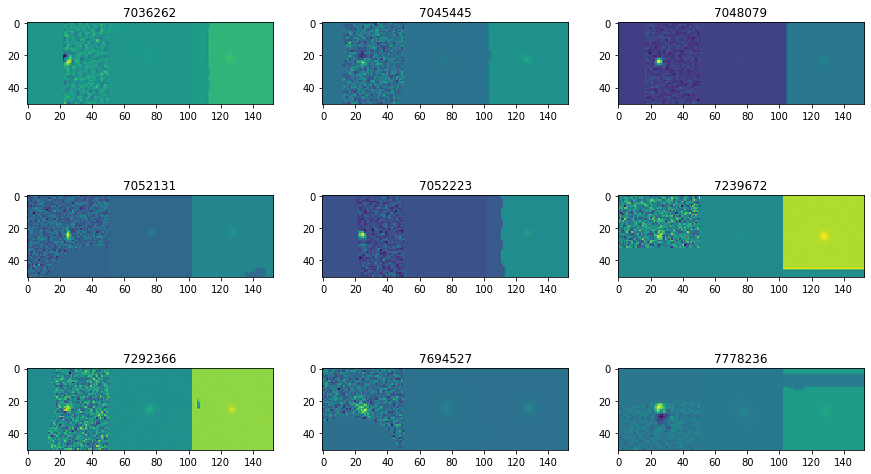

In [49]:
fig, ax = plt.subplots(3,3, figsize= (15,9))
l = 0
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(final_bogcl[group_BR["index"][l]])
        ax[i,j].set_title("{}".format(ID_1.iloc[group_BR["index"][l]]["ID"]))
        l = l+1

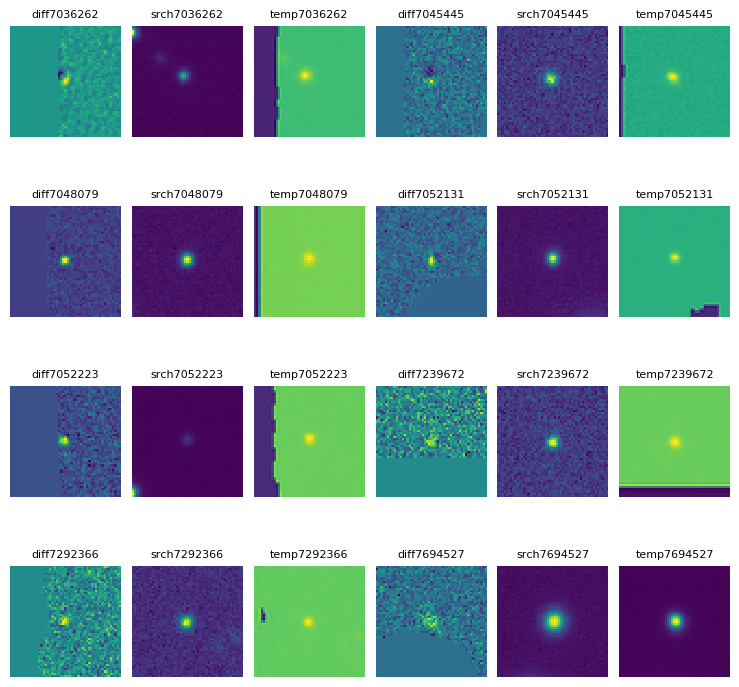

In [176]:
fig, ax = plt.subplots(4,2*3, figsize= (8,8))
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.1, -0.0001)
for i in range(8*3):
    ax[i//6,i%6].axis("off")
    ax[i//6,i%6].imshow(boglc_norm[group_BR["index"][i//3]*3+i%3])
    ax[i//6,i%6].set_title("{}{}".format(flist[i%3].split('/')[-1][0:4],ID_1.iloc[group_BR["index"][i//3]]["ID"]), fontsize = 8) 
#plt.savefig("tsnegroupBR.pdf",bbox_inches="tight")

# No-normalized

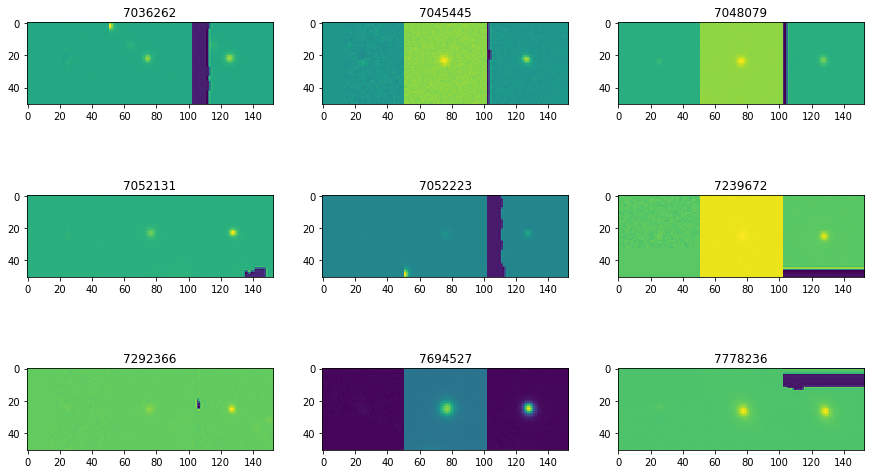

In [50]:
fig, ax = plt.subplots(3,3, figsize= (15,9))
l = 0
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(nonorm_bogcl[group_BR["index"][l]])
        ax[i,j].set_title("{}".format(ID_1.iloc[group_BR["index"][l]]["ID"]))
        l = l+1

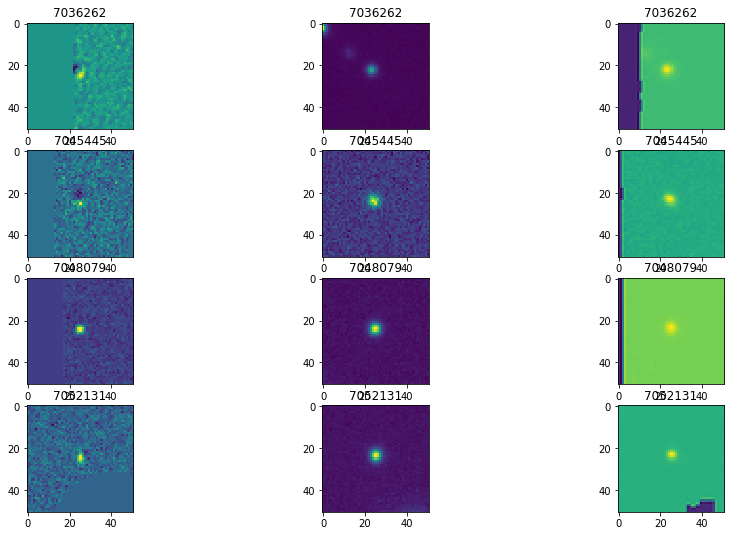

In [51]:
fig, ax = plt.subplots(4,3, figsize= (15,9))
l = 0
for i in range(4):
    k = 0
    for j in range(3):
        if k < 3:
            ax[i,j].imshow(boglc[(group_BR["index"][l]*3)+k])
            ax[i,j].set_title("{}".format(ID_1.iloc[group_BR["index"][l]]["ID"]))
            k = k+1
    l = l+1

Text(0, 0.5, 'tsne_50_y')

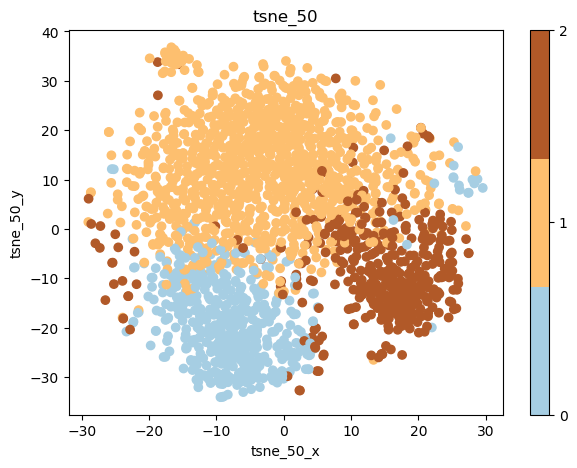

In [47]:
#fig, ax = plt.subplots(1,2, figsize = (10,5))
# ax[0].scatter(tsne_8[:,0], tsne_8[:,1], c = cluster_map['cluster3'], label = cluster_map['cluster3'].value_counts())
# ax[0].set_title("tsne_8 \n %s" %cluster_map['cluster3'].value_counts())


# ass3 = ax[1].scatter(tsne_50[:,0], tsne_50[:,1], clim=[-0.5, 3 - 0.5], c = cluster_map['cluster3'])
# ax[1].set_title("tsne_50")

# fig.colorbar(ass3, ticks=range(3))


plt.style.use('default')
fig, ax = plt.subplots(figsize = (7,5))

cmap = plt.get_cmap('Paired', 3)
scatter3 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = cluster_map['cluster3'],cmap = cmap)
plt.colorbar(scatter3, ticks = np.arange(3))
plt.title("tsne_50")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

#plt.savefig("tsne50+3kmean.pdf",bbox_inches="tight")




Text(0, 0.5, 'tsne_50_y')

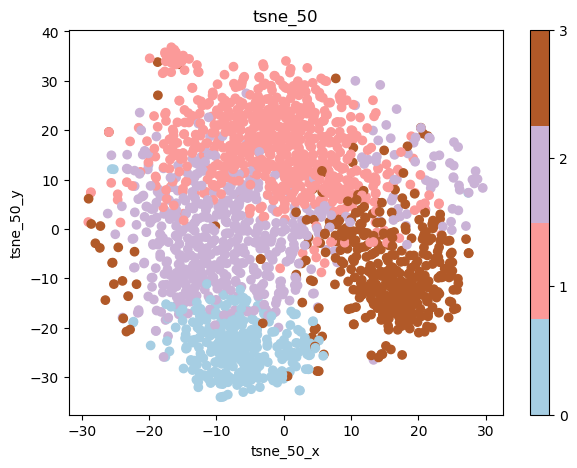

In [48]:
# fig, ax = plt.subplots(1,2, figsize = (10,5))
# ax[0].scatter(tsne_8[:,0], tsne_8[:,1], c = cluster_map['cluster4'], label = cluster_map['cluster4'].value_counts())
# ax[0].set_title("tsne_8 \n %s" %cluster_map['cluster4'].value_counts())

# ass4 = ax[1].scatter(tsne_50[:,0], tsne_50[:,1], clim=[-0.5, 4 - 0.5], c = cluster_map['cluster4'])
# ax[1].set_title("tsne_50")

# fig.colorbar(ass4, ticks=range(4))

plt.style.use('default')
fig, ax = plt.subplots(figsize = (7,5))

cmap = plt.get_cmap('Paired', 4)
scatter4 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = cluster_map['cluster4'],cmap = cmap)
plt.colorbar(scatter4, ticks = np.arange(4))
plt.title("tsne_50")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

#plt.savefig("tsne50+4kmean.pdf",bbox_inches="tight")





In [54]:
#reee = pd.merge(pd.DataFrame(tsne_y_positive,columns=['index', "tsne_y_50"]),pd.DataFrame(tsne_x_less_m15,columns=['index', "tsne_x_50"]))
#reee["index"][0]
#a2 = [reee["index"][i] for i in range(len(reee)) if reee["index"][i] in cluster_map[cluster_map['cluster3'] == 0].index.to_numpy()]

Text(0, 0.5, 'tsne_50_y')

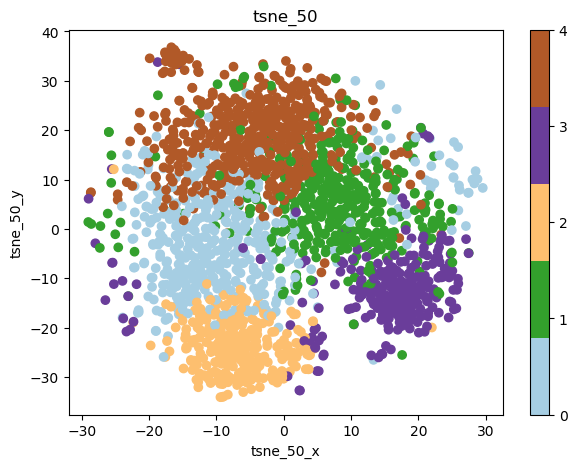

In [49]:
# fig, ax = plt.subplots(1,2, figsize = (10,5))
# ax[0].scatter(tsne_8[:,0], tsne_8[:,1], c = cluster_map['cluster5'], label = cluster_map['cluster5'].value_counts())
# ax[0].set_title("tsne_8 \n %s" %cluster_map['cluster5'].value_counts())

# ass6 = ax[1].scatter(tsne_50[:,0], tsne_50[:,1], clim=[-0.5, 5 - 0.5], c = cluster_map['cluster5'])
# ax[1].set_title("tsne_50")

# fig.colorbar(ass6, ticks=range(5))

plt.style.use('default')
fig, ax = plt.subplots(figsize = (7,5))

cmap = plt.get_cmap('Paired', 5)
scatter5 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = cluster_map['cluster5'],cmap = cmap)
plt.colorbar(scatter5, ticks = np.arange(5))
plt.title("tsne_50")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

#plt.savefig("tsne50+5kmean.pdf",bbox_inches="tight")

Text(0, 0.5, 'tsne_50_y')

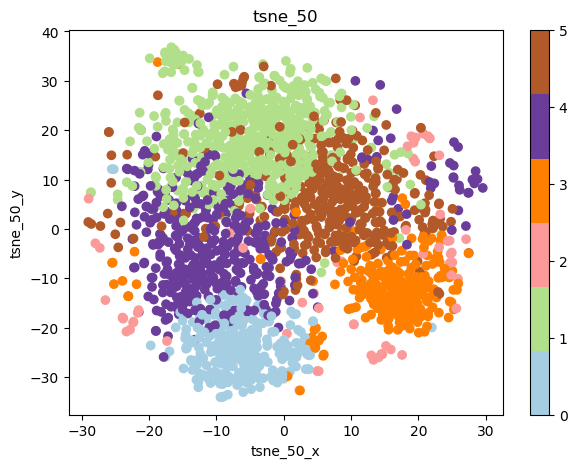

In [50]:
# fig, ax = plt.subplots(1,2, figsize = (10,5))
# ax[0].scatter(tsne_8[:,0], tsne_8[:,1], c = cluster_map['cluster6'], label = cluster_map['cluster6'].value_counts())
# ax[0].set_title("tsne_8 \n %s" %cluster_map['cluster6'].value_counts())

# ass6 = ax[1].scatter(tsne_50[:,0], tsne_50[:,1], clim=[-0.5, 6 - 0.5], c = cluster_map['cluster6'])
# ax[1].set_title("tsne_50")

# fig.colorbar(ass6, ticks=range(6))


plt.style.use('default')
fig, ax = plt.subplots(figsize = (7,5))

cmap = plt.get_cmap('Paired', 6)
scatter6 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = cluster_map['cluster6'],cmap = cmap)
plt.colorbar(scatter6, ticks = np.arange(6))
plt.title("tsne_50")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

#plt.savefig("tsne50+6kmean.pdf",bbox_inches="tight")


In [52]:
#cluster_map["tsne_x_8"] = tsne_8[:,0]
#cluster_map["tsne_y_8"] = tsne_8[:,1]
cluster_map["tsne_x_50"] = tsne_50[:,0]
cluster_map["tsne_y_50"] = tsne_50[:,1]

In [53]:
cluster_map

cluster2  cluster3  cluster4  cluster5  cluster6  tsne_x_50  tsne_y_50
0            0         1         1         4         1 -13.266938   7.204411
1            1         2         3         3         3  18.266649 -11.780096
2            1         0         2         0         4  -6.834410 -13.604616
3            1         2         3         3         3  17.631472 -14.809234
4            1         0         0         2         0 -11.834247 -29.629759
...        ...       ...       ...       ...       ...        ...        ...
1892         1         2         3         3         3  16.472118  -5.306389
1893         0         2         3         1         5   6.112151  -0.921989
1894         1         2         3         3         2  23.059608  -3.708853
1895         0         1         1         4         1  -0.619461  30.058378
1896         0         1         1         1         5   4.669233   8.762587

[1897 rows x 7 columns]

# DBSCAN for eps = 0.57, 0.5 and 0.45

In [54]:
from sklearn.cluster import DBSCAN
import collections

In [55]:
db = DBSCAN(eps = 0.57,min_samples=10).fit(layer_output[0])
db

DBSCAN(algorithm='auto', eps=0.57, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [56]:
collections.Counter(db.labels_)

Counter({0: 1868, -1: 29})

(array([  29.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1868.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <a list of 10 Patch objects>)

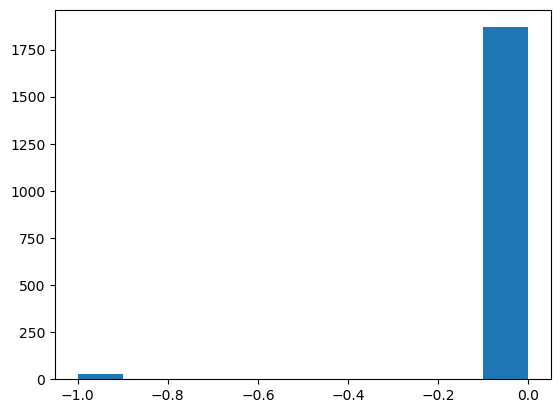

In [57]:
db_map = pd.DataFrame()
db_map['cluster'] = db.labels_
plt.hist(db.labels_)
    

In [63]:
#db.core_sample_indices_

In [64]:
#db.components_.shape

In [58]:
db_map

cluster
0           0
1           0
2           0
3           0
4           0
...       ...
1892        0
1893        0
1894        0
1895        0
1896        0

[1897 rows x 1 columns]

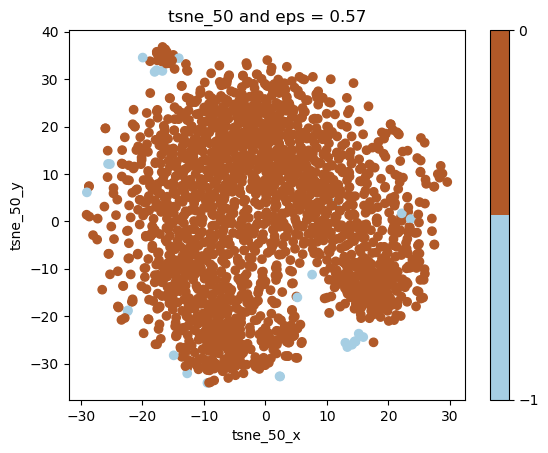

In [84]:

# cmap = plt.get_cmap('Paired', 2)
# plot = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db_map['cluster'], cmap = cmap)
# plt.colorbar(plot, ticks = [0,1])


cmap = plt.get_cmap('Paired', 2)
scatter2 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db_map['cluster'],cmap = cmap)
plt.colorbar(scatter2, ticks = [0,-1])
plt.title("tsne_50 and eps = 0.57")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

plt.savefig("tsne50+0.57eps.pdf",bbox_inches="tight")


# Plot group -1, the blue one

In [67]:
db_map[db_map["cluster"]==-1].index.to_numpy()

array([  40,   89,  173,  342,  364,  480,  751,  784,  822,  832,  909,
        940,  956,  962,  980, 1034, 1089, 1111, 1115, 1152, 1218, 1222,
       1230, 1349, 1508, 1571, 1620, 1874, 1891])

# Normalize

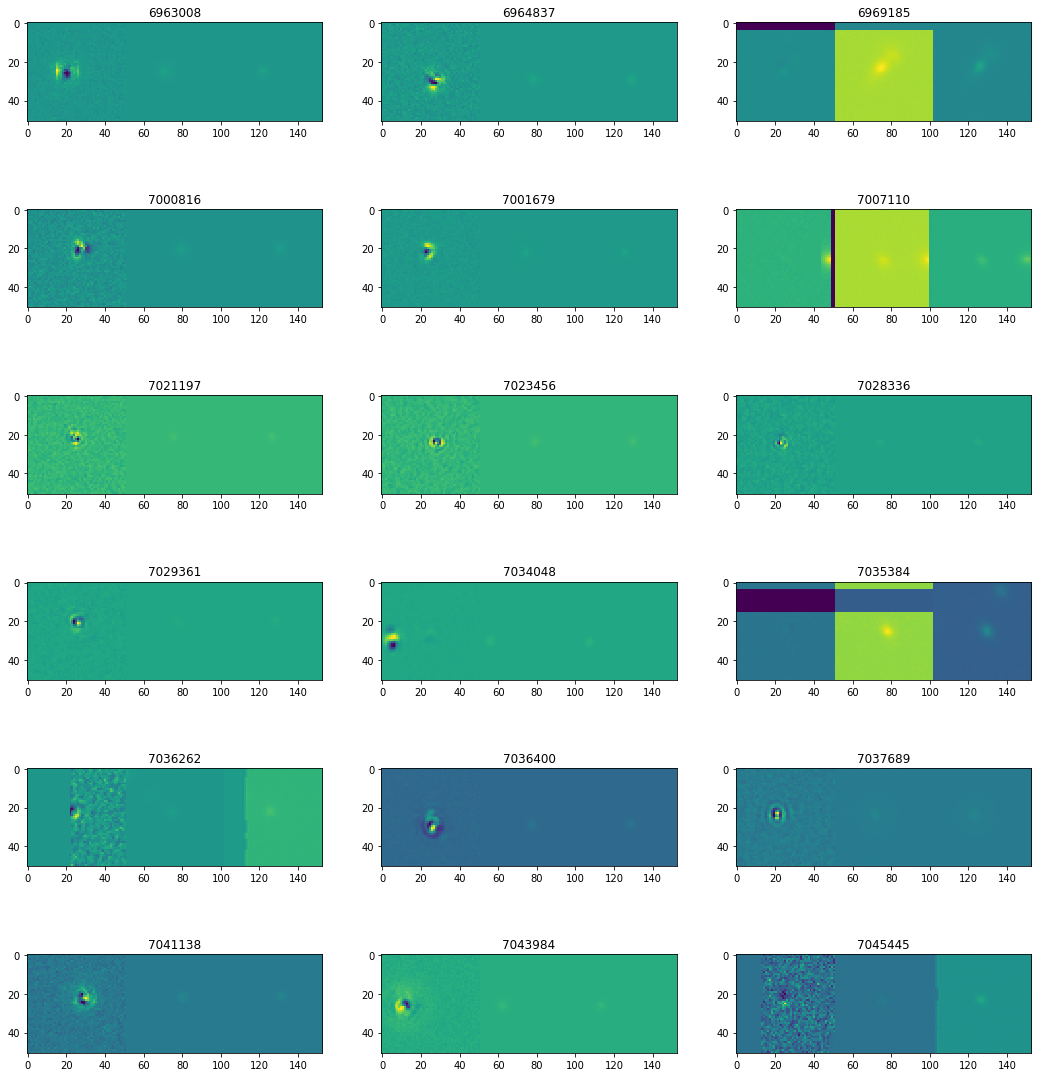

In [68]:
fig, ax = plt.subplots(6,3, figsize= (18,20))
k = 0
for i in range(6):
    for j in range(3):
        ax[i,j].imshow(final_bogcl[db_map[db_map["cluster"]==-1].index.to_numpy()[k]])
        ax[i,j].set_title("{}".format(ID_1.iloc[db_map[db_map["cluster"]==-1].index.to_numpy()[k]]["ID"]))
        k =k+1

# No-Normalize

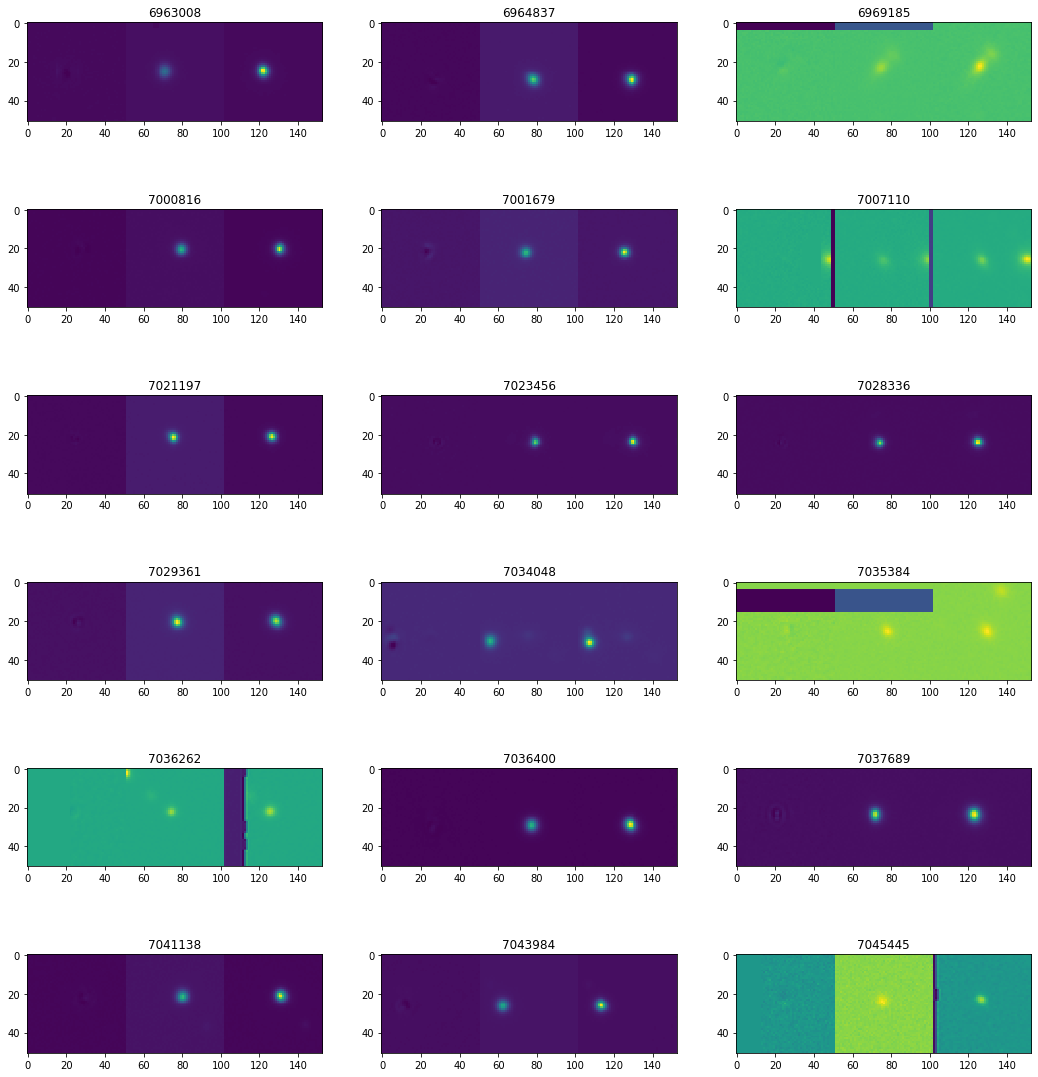

In [69]:
fig, ax = plt.subplots(6,3, figsize= (18,20))
k = 0
for i in range(6):
    for j in range(3):
        ax[i,j].imshow(nonorm_bogcl[db_map[db_map["cluster"]==-1].index.to_numpy()[k]])
        ax[i,j].set_title("{}".format(ID_1.iloc[db_map[db_map["cluster"]==-1].index.to_numpy()[k]]["ID"]))
        k =k+1

# eps = 0.5

In [69]:
db1 = DBSCAN(eps = 0.5,min_samples=10).fit(layer_output[0])
db1

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [70]:
collections.Counter(db1.labels_)

Counter({0: 1834, -1: 63})

(array([  63.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1834.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <a list of 10 Patch objects>)

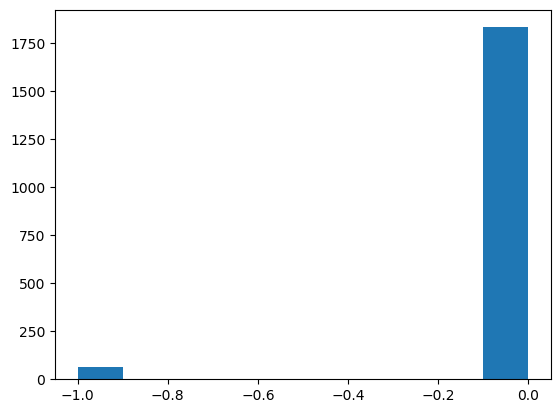

In [71]:
db1_map = pd.DataFrame()
db1_map['cluster'] = db1.labels_
plt.hist(db1.labels_)

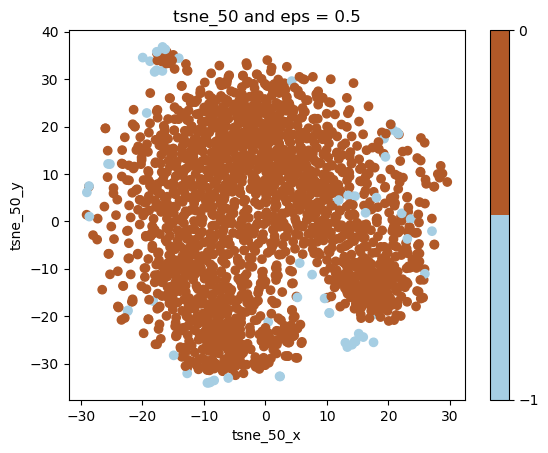

In [85]:
# plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db1_map['cluster'], cmap = 'Paired')
# plt.colorbar(plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db1_map['cluster'],cmap = 'Paired'))


cmap = plt.get_cmap('Paired', 2)
scatter2 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db1_map['cluster'],cmap = cmap)
plt.colorbar(scatter2, ticks = [0,-1])
plt.title("tsne_50 and eps = 0.5")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

plt.savefig("tsne50+0.5eps.pdf",bbox_inches="tight")

# Plot cluster -1

# Normalize

In [74]:
db1_map[db1_map["cluster"]==-1].index.to_numpy()

array([  40,   89,   90,   99,  173,  205,  342,  364,  480,  623,  681,
        751,  776,  778,  779,  784,  822,  825,  832,  835,  891,  909,
        938,  940,  952,  956,  962,  963,  980,  996, 1023, 1034, 1060,
       1069, 1089, 1111, 1115, 1120, 1152, 1176, 1218, 1222, 1230, 1265,
       1273, 1277, 1309, 1322, 1332, 1334, 1343, 1349, 1354, 1508, 1571,
       1620, 1680, 1732, 1753, 1786, 1874, 1891, 1894])

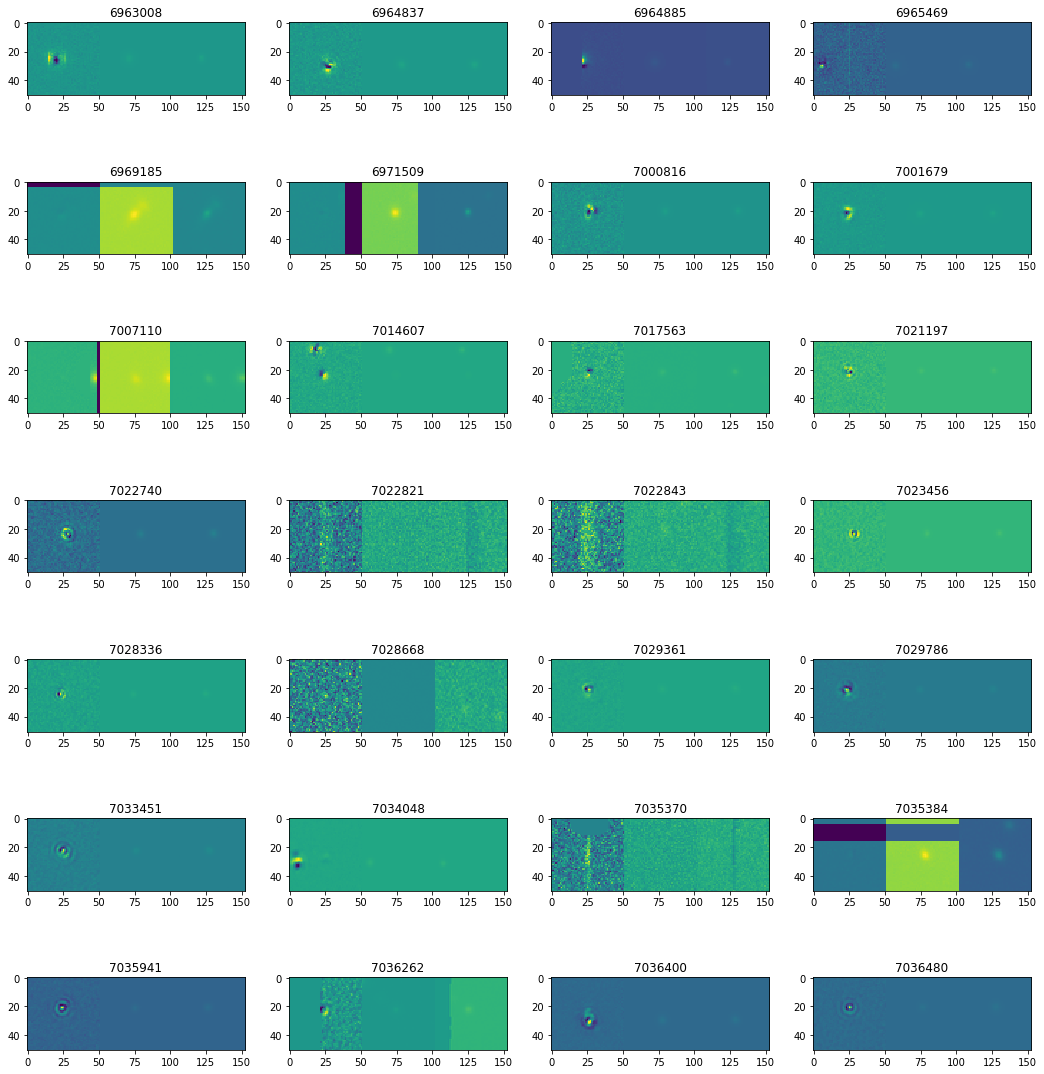

In [75]:
fig, ax = plt.subplots(7,4, figsize= (18,20))
k = 0
for i in range(7):
    for j in range(4):
        ax[i,j].imshow(final_bogcl[db1_map[db1_map["cluster"]==-1].index.to_numpy()[k]])
        ax[i,j].set_title("{}".format(ID_1.iloc[db1_map[db1_map["cluster"]==-1].index.to_numpy()[k]]["ID"]))
        k =k+1

# No-normalize

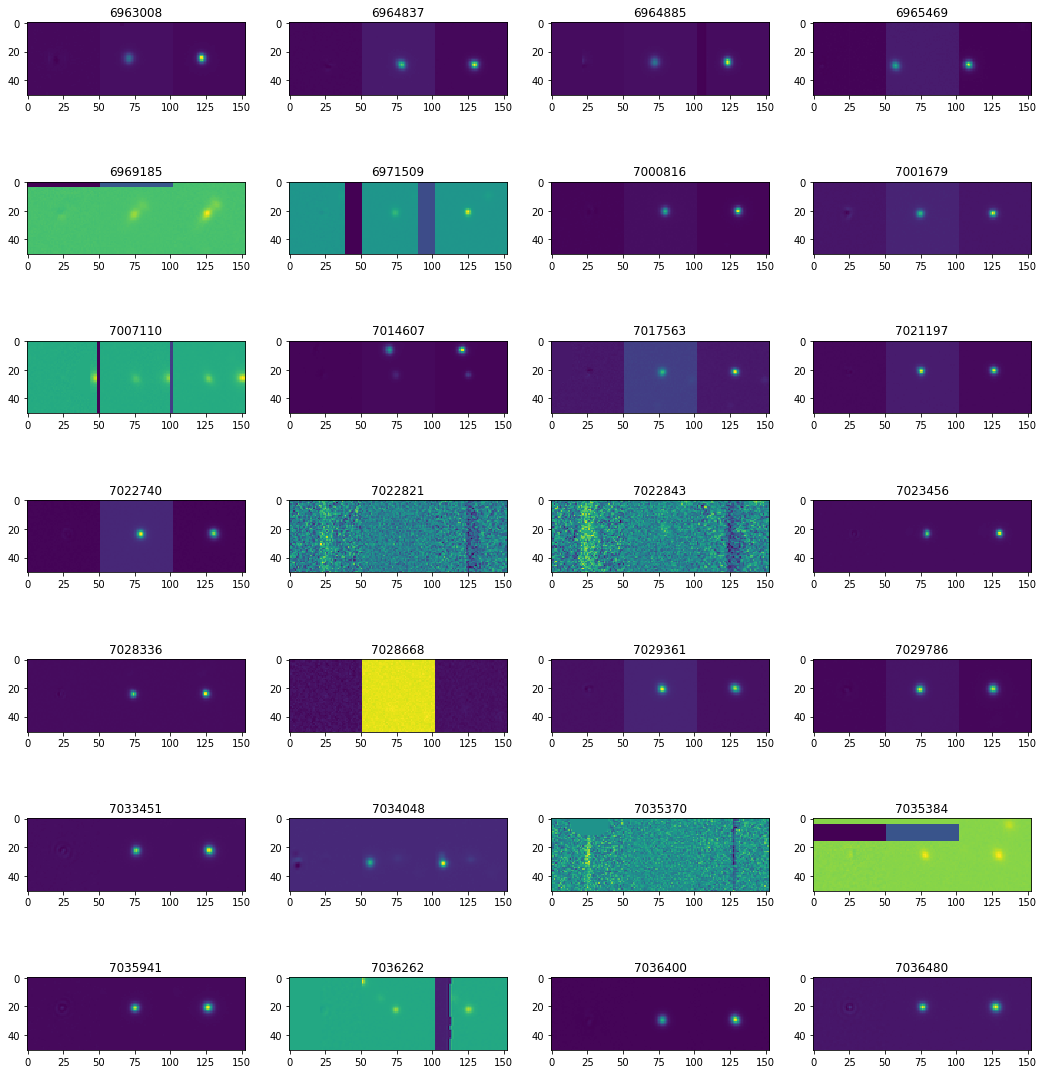

In [76]:
fig, ax = plt.subplots(7,4, figsize= (18,20))
k = 0
for i in range(7):
    for j in range(4):
        ax[i,j].imshow(nonorm_bogcl[db1_map[db1_map["cluster"]==-1].index.to_numpy()[k]])
        ax[i,j].set_title("{}".format(ID_1.iloc[db1_map[db1_map["cluster"]==-1].index.to_numpy()[k]]["ID"]))
        k =k+1

In [77]:
db1_map[db1_map["cluster"]==0].index.to_numpy()

array([   0,    1,    2, ..., 1893, 1895, 1896])

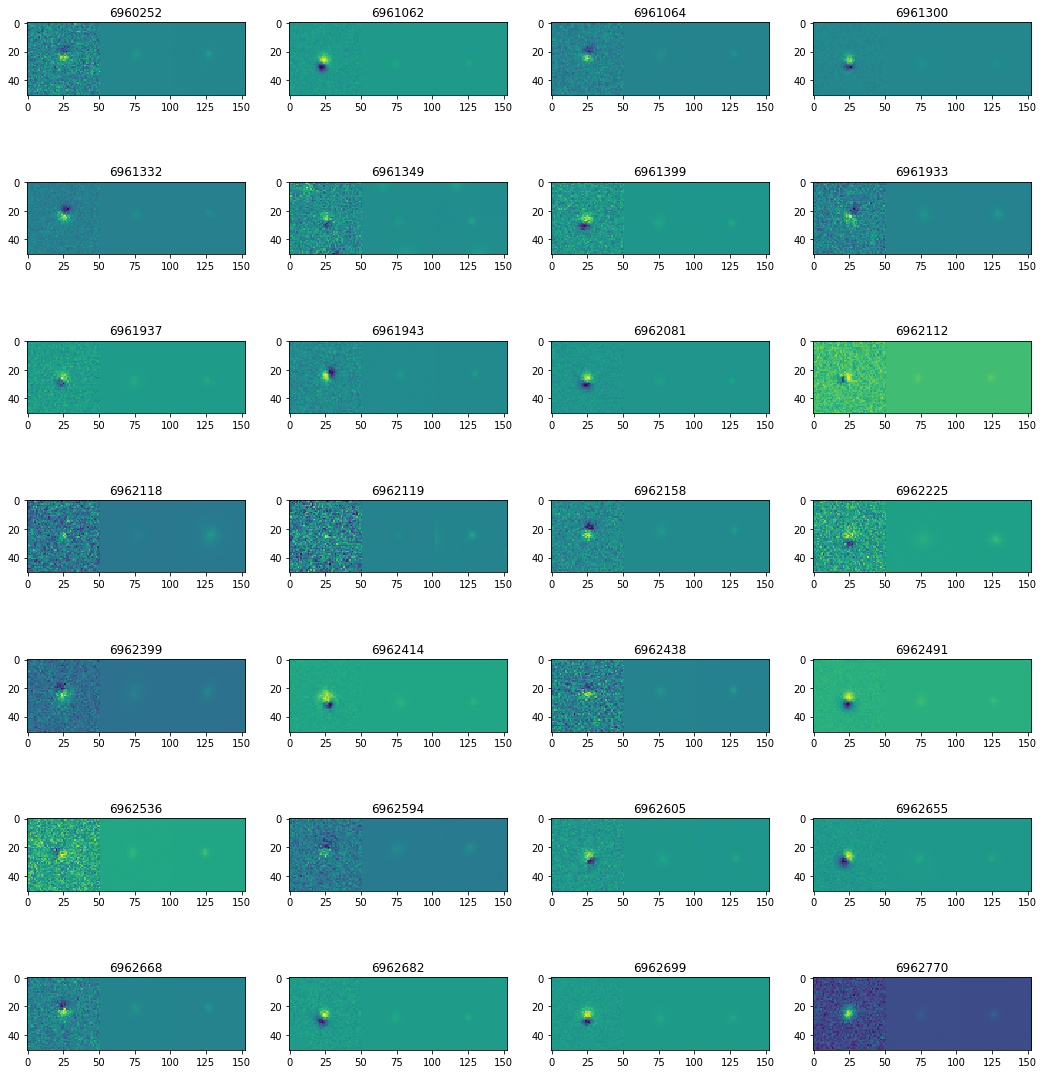

In [78]:
fig, ax = plt.subplots(7,4, figsize= (18,20))
k = 0
for i in range(7):
    for j in range(4):
        ax[i,j].imshow(final_bogcl[db1_map[db1_map["cluster"]==0].index.to_numpy()[k]])
        ax[i,j].set_title("{}".format(ID_1.iloc[db1_map[db1_map["cluster"]==0].index.to_numpy()[k]]["ID"]))
        k =k+1

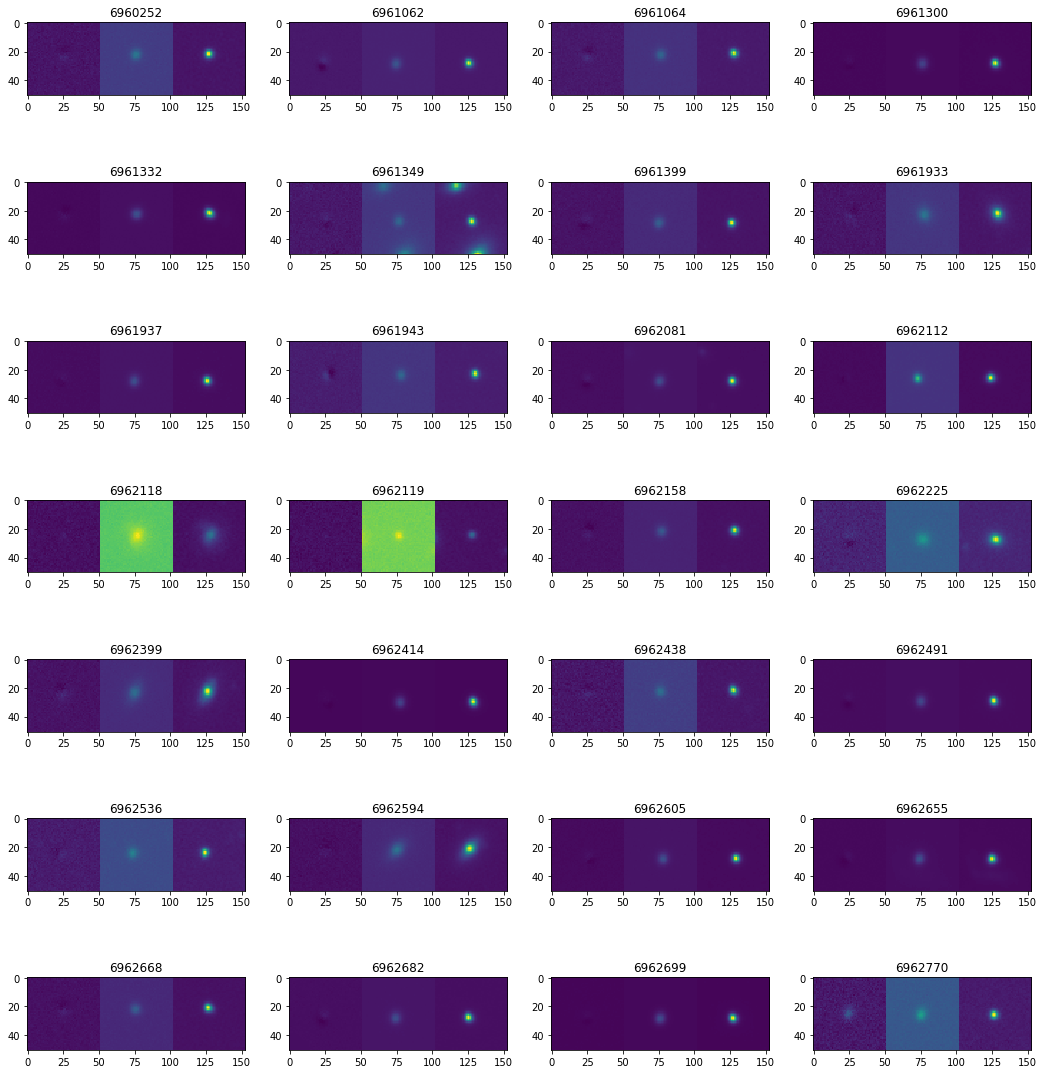

In [79]:
fig, ax = plt.subplots(7,4, figsize= (18,20))
k = 0
for i in range(7):
    for j in range(4):
        ax[i,j].imshow(nonorm_bogcl[db1_map[db1_map["cluster"]==0].index.to_numpy()[k]])
        ax[i,j].set_title("{}".format(ID_1.iloc[db1_map[db1_map["cluster"]==0].index.to_numpy()[k]]["ID"]))
        k =k+1

# eps = 0.45

In [76]:
db2 = DBSCAN(eps = 0.45,min_samples=10).fit(layer_output[0])
db2

DBSCAN(algorithm='auto', eps=0.45, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [77]:
collections.Counter(db2.labels_)

Counter({0: 1791, -1: 106})

(array([ 106.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1791.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <a list of 10 Patch objects>)

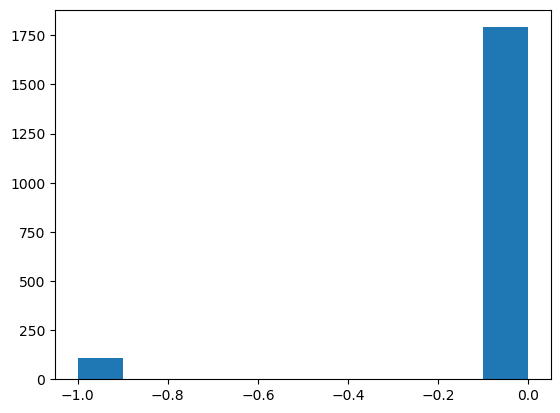

In [78]:
db2_map = pd.DataFrame()
db2_map['cluster'] = db2.labels_
plt.hist(db2.labels_)

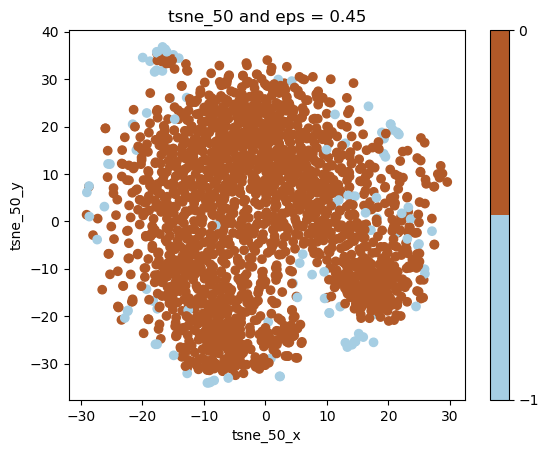

In [86]:
# plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db2_map['cluster'], cmap = 'Paired')
# plt.colorbar(plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db2_map['cluster'],cmap = 'Paired'))

cmap = plt.get_cmap('Paired', 2)
scatter2 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db2_map['cluster'],cmap = cmap)
plt.colorbar(scatter2, ticks = [0,-1])
plt.title("tsne_50 and eps = 0.45")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

plt.savefig("tsne50+0.45eps.pdf",bbox_inches="tight")

# eps = 0.338

In [80]:
db3 = DBSCAN(eps = 0.338,min_samples=10).fit(layer_output[0])
db3

DBSCAN(algorithm='auto', eps=0.338, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [81]:
collections.Counter(db3.labels_)

Counter({-1: 892, 0: 995, 1: 10})

(array([892.,   0.,   0.,   0.,   0., 995.,   0.,   0.,   0.,  10.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

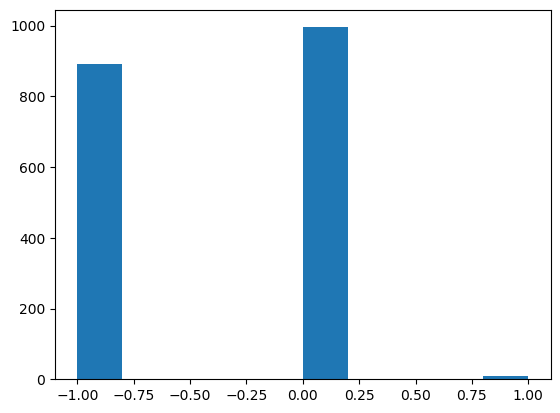

In [82]:
db3_map = pd.DataFrame()
db3_map['cluster'] = db3.labels_
plt.hist(db3.labels_)

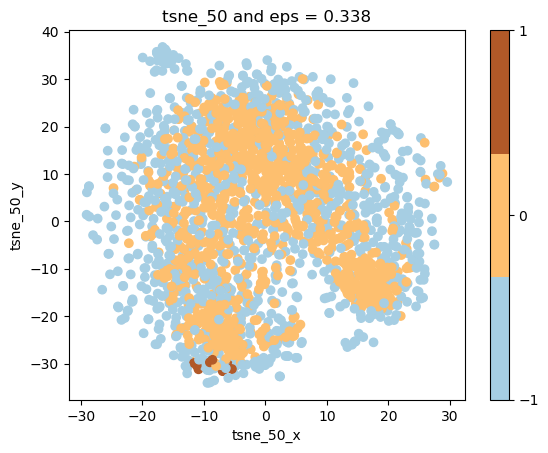

In [87]:
# plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db3_map['cluster'], cmap = 'Paired')
# plt.colorbar(plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db3_map['cluster'],cmap = 'Paired'))

cmap = plt.get_cmap('Paired', 3)
scatter2 = plt.scatter(tsne_50[:,0], tsne_50[:,1], c = db3_map['cluster'],cmap = cmap)
plt.colorbar(scatter2, ticks = [0,-1,1])
plt.title("tsne_50 and eps = 0.338")
plt.xlabel("tsne_50_x")
plt.ylabel("tsne_50_y")

plt.savefig("tsne50+0.338eps.pdf",bbox_inches="tight")

# Plot cluster 1, the brown one

In [88]:
db3_map[db3_map["cluster"]==1].index

Int64Index([220, 304, 606, 695, 721, 742, 829, 860, 1208, 1530], dtype='int64')

# Normalize

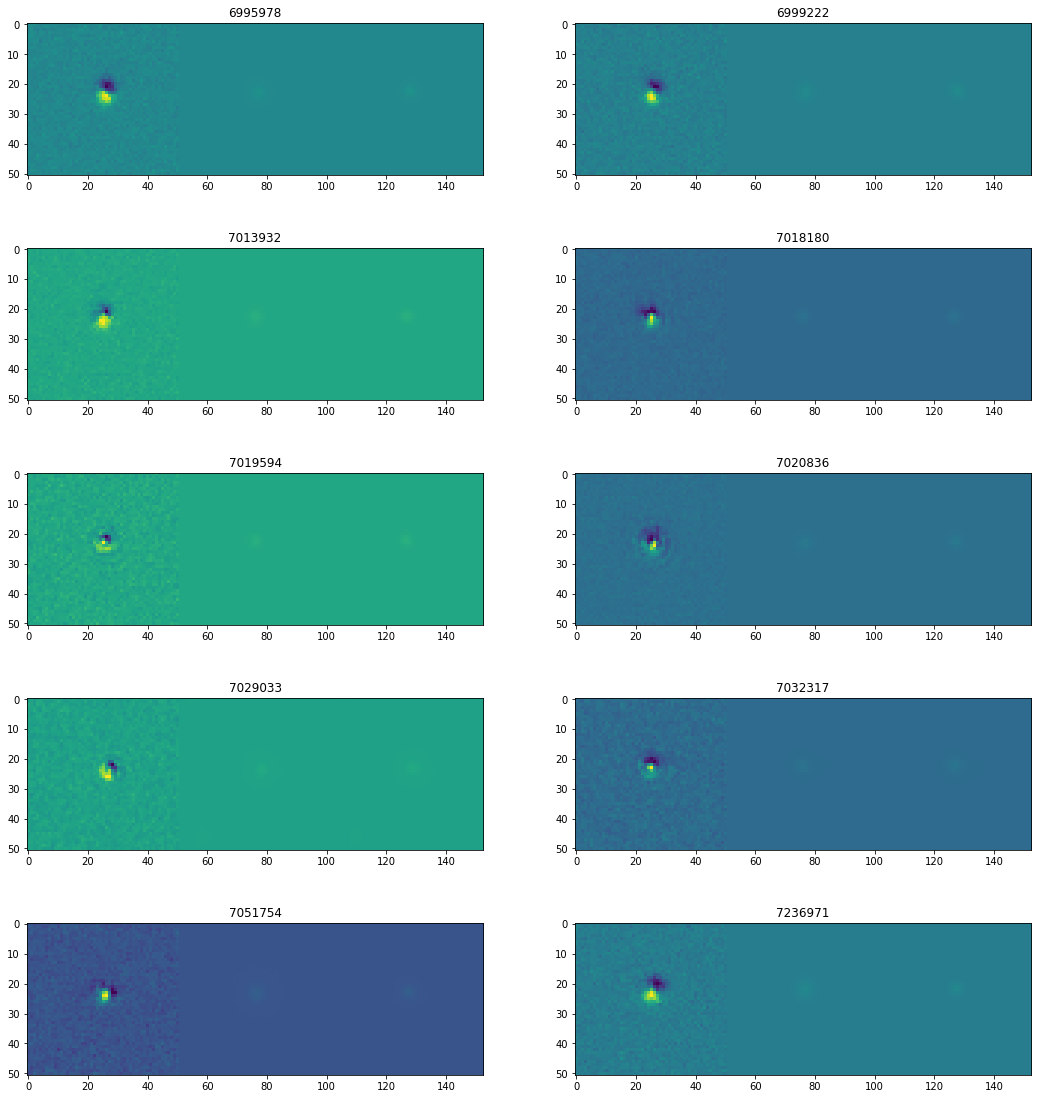

In [89]:
fig, ax = plt.subplots(5,2, figsize= (18,20))
k = 0
for i in range(5):
    for j in range(2):
        ax[i,j].imshow(final_bogcl[db3_map[db3_map["cluster"]==1].index.to_numpy()[k]])
        ax[i,j].set_title("{}".format(ID_1.iloc[db3_map[db3_map["cluster"]==1].index.to_numpy()[k]]["ID"]))
        k =k+1

# No-normalize

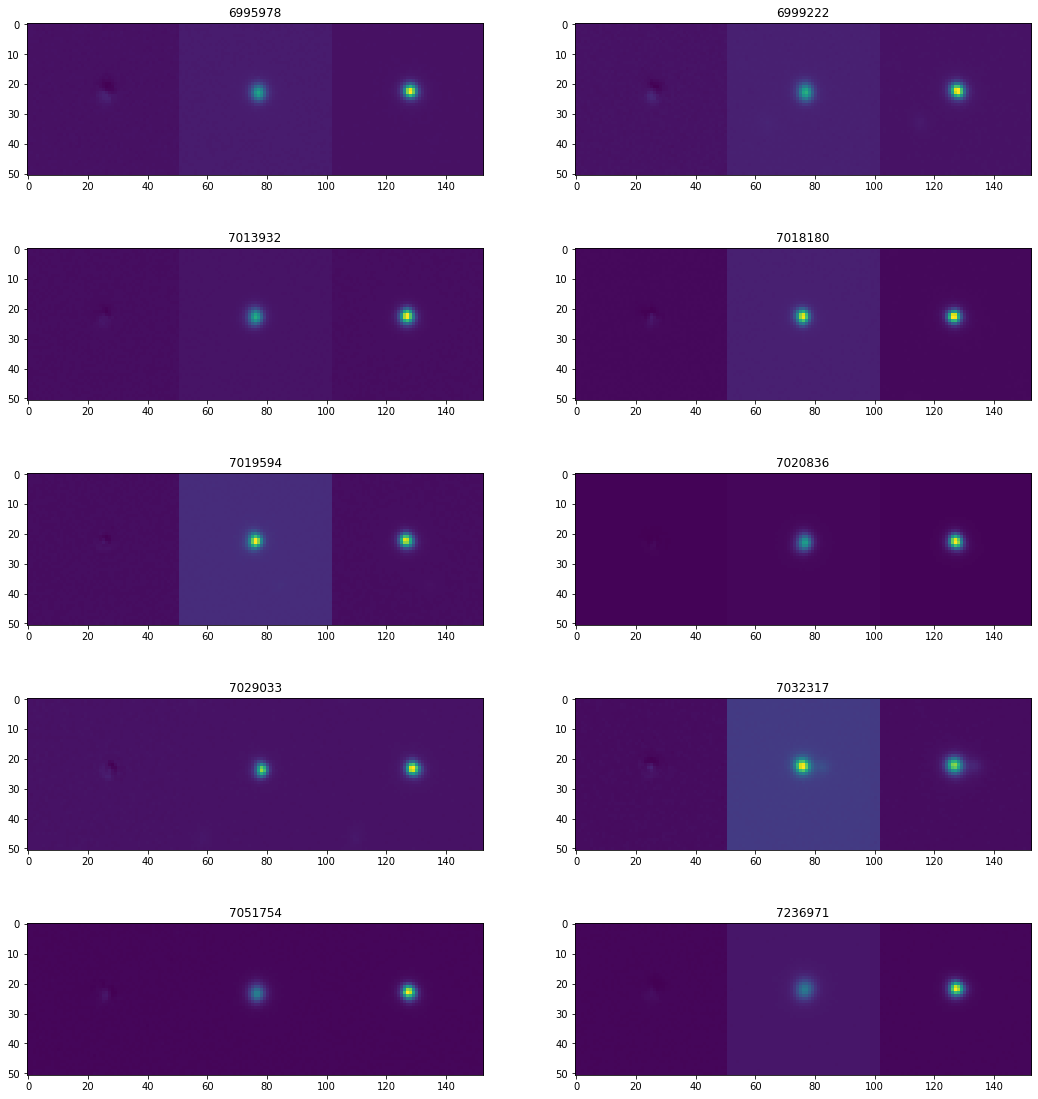

In [90]:
fig, ax = plt.subplots(5,2, figsize= (18,20))
k = 0
for i in range(5):
    for j in range(2):
        ax[i,j].imshow(nonorm_bogcl[db3_map[db3_map["cluster"]==1].index.to_numpy()[k]])
        ax[i,j].set_title("{}".format(ID_1.iloc[db3_map[db3_map["cluster"]==1].index.to_numpy()[k]]["ID"]))
        k =k+1